In [1]:
%%capture
%run part03_preparation.ipynb

In [114]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

import sys
import os
from datetime import datetime

import pickle

from mlflow.models.signature import infer_signature


#Visualization Tools
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


# Machine Learning Models
from lightgbm import LGBMClassifier

# Model Selection Tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
#import optuna

# Model Evaluation Tools
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
ROOT_DIR = '/home/alysson/projects/Hotel-Booking-Cancelations'
MLFLOW_DIR = '/home/alysson/projects/Hotel-Booking-Cancelations/mlflow'
MLFLOW_PLOTS_FOLDER = '/home/alysson/projects/Hotel-Booking-Cancelations/mlflow/plots'
MLFLOW_CONFUSION_MATRIX_PATH = '/home/alysson/projects/Hotel-Booking-Cancelations/mlflow/plots/confusion_matrix.png'

In [9]:
os.makedirs(MLFLOW_DIR, exist_ok=True)
os.makedirs(MLFLOW_PLOTS_FOLDER, exist_ok=True)

In [10]:
if MLFLOW_DIR not in sys.path:
    sys.path.append(MLFLOW_DIR)
os.chdir(MLFLOW_DIR)

In [11]:
!pwd

/home/alysson/projects/Hotel-Booking-Cancelations/mlflow


In [13]:
def get_metrics(y_true, y_pred, y_pred_prob):    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'Accuracy': round(acc, 3), 
            'Precision': round(prec, 3), 
            'Recall': round(recall, 3), 
            'F1': round(f1, 3),
            'Auc': round(auc, 3),
            'Entropy': round(entropy, 3)}

In [14]:
def CM(y, y_pred, save=False): 
    
        labels = ["Não Cancelado", "Cancelado"]
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
        disp.plot(cmap="Blues", values_format="d")          
        
        if save == True:
            plt.savefig(MLFLOW_CONFUSION_MATRIX_PATH, dpi=120)
            
        plt.show() 
        print("Score: \n", classification_report(y,y_pred))  

In [15]:
def CVS(model, X, y, model_dict=''):
   
    number_folds = 5    
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    
    y_prob = cross_val_predict(model, X, y, cv=Kfold, method='predict_proba', verbose=False)    
    y_prob = y_prob[:,1]
    
    ### Defining threshold ###
    y_pred = np.empty(shape=(len(y_prob)))
    threshold = 0.5
    for i in range(len(y_prob)):    
        if y_prob[i] >= threshold:
            y_pred[i] = 1  
        else:
            y_pred[i] = 0
  
    scores = cross_validate(model, X, y, cv = Kfold, scoring=['accuracy','precision','recall','f1','roc_auc'], return_train_score=True)
    
    df = pd.DataFrame.from_dict(scores).T
    df['value'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    display(df[['value','std']])    
    
    return y_prob, y_pred

### Start

In [16]:
filepath = '/home/alysson/projects/Hotel-Booking-Cancelations/models/lgbm/lgbm_11-06-23.pkl'
with open(filepath, 'rb') as file:
    lgbm = pickle.load(file)

In [17]:
lgbm

LGBMClassifier(learning_rate=0.075, max_depth=12, min_child_samples=1,
               num_leaves=200, objective='binary', reg_alpha=0.002,
               reg_lambda=0.25, scale_pos_weight=2.631, subsample_freq=2)

In [80]:
lgbm.get_params

<bound method LGBMModel.get_params of LGBMClassifier(learning_rate=0.075, max_depth=12, min_child_samples=1,
               num_leaves=200, objective='binary', reg_alpha=0.002,
               reg_lambda=0.25, scale_pos_weight=2.631, subsample_freq=2)>

In [19]:
run_params = {'objective': 'binary', 
              'boosting_type': 'gbdt', 
              'num_leaves': 220, 
              'max_depth': 7, 
              'learning_rate': 0.075, 
              'reg_alpha': 0.002, 
              'reg_lambda': 0.025, 
              'subsample_freq': 2, 
              'min_child_samples': 1, 
              'scale_pos_weight': 2.7}

In [20]:
lgbm_model = LGBMClassifier(**run_params)

In [21]:
lgbm_y_prob, lgbm_y_pred  = CVS(lgbm_model,X,y,'LightGBM')

,value,std
fit_time,0.199953,0.030698
score_time,0.036689,0.001091
test_accuracy,0.770394,0.000744
train_accuracy,0.778649,0.000819
test_precision,0.551388,0.001167
train_precision,0.560657,0.001078
test_recall,0.891779,0.004210
train_recall,0.906691,0.001160
test_f1,0.681434,0.000486
train_f1,0.692872,0.000697


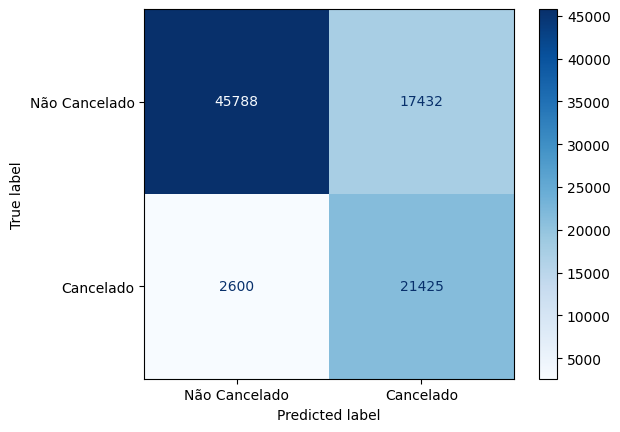

Score: 
               precision    recall  f1-score   support

           0       0.95      0.72      0.82     63220
           1       0.55      0.89      0.68     24025

    accuracy                           0.77     87245
   macro avg       0.75      0.81      0.75     87245
weighted avg       0.84      0.77      0.78     87245



In [22]:
CM(y, lgbm_y_pred, save=True)

In [23]:
METRICS = get_metrics(y, lgbm_y_pred, lgbm_y_prob)

{'Accuracy': 0.77,
 'Precision': 0.551,
 'Recall': 0.892,
 'F1': 0.681,
 'Auc': 0.808,
 'Entropy': 0.427}

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

In [107]:
data = data.astype({"hotel": 'str', 
                    "is_canceled": float,
                    "lead_time": float, 
                    "arrival_date_year": float, 
                    "arrival_date_month": 'str', 
                    "arrival_date_week_number": float, 
                    "arrival_date_day_of_month": float, 
                    "stays_in_weekend_nights": float, 
                    "stays_in_week_nights": float, 
                    "adults": float, 
                    "children": float, 
                    "babies": float,
                    "meal": 'str',
                    "country": 'str', 
                    "market_segment": 'str', 
                    "distribution_channel": 'str',
                    "is_repeated_guest": float, 
                    "previous_cancellations": float, 
                    "previous_bookings_not_canceled": float, 
                    "reserved_room_type": 'str', 
                    "assigned_room_type": 'str', 
                    "booking_changes": float,
                    "deposit_type": 'str', 
                    "agent": float, 
                    "company": float, 
                    "days_in_waiting_list": float, 
                    "customer_type": 'str',
                    "adr": float,
                    "required_car_parking_spaces": float,
                    "total_of_special_requests": float,
                    "reservation_status": 'str',
                    "reservation_status_date": 'str',
                    "people": float,
                    "kids": float,
                    "days_stay": float,
                    "country_name": 'str',
                    "continentes": 'str'})

In [123]:
def create_experiment(experiment_name,
                      description,
                      run_name,
                      run_metrics,                      
                      model,
                      registered_model_name,
                      signature,
                      run_params = None,
                      confusion_matrix_path = None): 

    mlflow.set_tracking_uri("http://localhost:5000") 
    mlflow.set_experiment(experiment_name)
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    
    
    
    with mlflow.start_run(run_name=run_name,description=description) as run:        
    
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)
        X_train.shape, y_train.shape, X_val.shape, y_val.shape
        
        model = LGBMClassifier(**run_params)
        model.fit(X_train, y_train)

        #Infer the model signature
        y_pred = model.predict(X_val)       
    

        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])       
 
        if not confusion_matrix_path == None:
            mlflow.log_artifact(MLFLOW_CONFUSION_MATRIX_PATH, 'confusion_matrix')
            
            
        mlflow.set_tags({"tag1":"nlsaldlasd", "tag2":"Production"})
        
        
        #mlflow.lightgbm.autolog()
        
        mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="sklearn-model",
        serialization_format="cloudpickle",    
        signature=signature,
        registered_model_name=registered_model_name,
    )
        
        
        run_id = mlflow.active_run().info.run_id
        
    print(f'Run Name: {run_name}\nRun id: {run_id}\nExperiment Name: {experiment_name}\nExperiment ID: {experiment_id}')

## Run Experiment

In [125]:
experiment_name = 'Hotel Cancelations'
description= 'Offline Running'
run_name = 'LGBM'
run_metrics = METRICS
run_params = run_params
model = lgbm
registered_model_name = 'lgbmfinal'
confusion_matrix_path = MLFLOW_CONFUSION_MATRIX_PATH
signature = infer_signature(data[SELECTED_FEATURES], data[TARGET])

In [126]:
create_experiment(experiment_name=experiment_name, 
                  description=description,
                  run_name=run_name, 
                  run_metrics=run_metrics,
                  model=model,
                  registered_model_name=registered_model_name,
                  signature=signature,
                  run_params=run_params, 
                  confusion_matrix_path = confusion_matrix_path, 
                  )

Successfully registered model 'lgbmfinal'.
2023/06/12 09:23:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: lgbmfinal, version 1


Run Name: LGBM
Run id: 4022aa1f0d634d09a7882b4a3fd31aaf
Experiment Name: Hotel Cancelations
Experiment ID: 849774867254009182


Created version '1' of model 'lgbmfinal'.


## Register a Model using run_id

In [138]:
# import mlflow
# with mlflow.start_run(run_name=run_name) as run:
#     result = mlflow.register_model(
#         "runs:/165763a9ce3d4ef5926fb99346544ba9/model",
#         "finalmodel"
#     )
    
#utro Jeito de registar o modelo
result = mlflow.register_model(
    "runs:/4022aa1f0d634d09a7882b4a3fd31aaf/sklearn-model", "lgbm2"
)

Successfully registered model 'lgbm2'.
2023/06/12 09:31:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: lgbm2, version 1
Created version '1' of model 'lgbm2'.


## Register Other Models

In [73]:
# import mlflow
# client = mlflow.tracking.MlflowClient()
# client.create_registered_model("basic-classifier-method-7") #Cria um modelo pelado

In [72]:
# #the method below creates a new version of the model.
# client = mlflow.tracking.MlflowClient()
# result = client.create_model_version(
#     name="basic-classifier-method-7",
#     source="165763a9ce3d4ef5926fb99346544ba9/artifacts/model", 
#     run_id="165763a9ce3d4ef5926fb99346544ba9" # Pega um run_id nos experimentos qjue você quer
# )

### Load Model and Predict

In [69]:
model_name = "Outro Modelo"
model_version = 1
sklearn_model = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{model_version}")
sklearn_model.fit(X_train, y_train) 
y_pred_prob = sklearn_model.predict_proba(X_val)
#print(y_pred_prob)
print(y_pred_prob[:,1])

[0.80009376 0.27508141 0.02498051 ... 0.31701164 0.73889546 0.04081293]


### Mudando o stage do modelo

In [131]:
#Jeito 1
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name="lgbmfinal",
    version=1,
    stage="Production"
)

<ModelVersion: aliases=[], creation_timestamp=1686572606164, current_stage='Production', description='', last_updated_timestamp=1686572889709, name='lgbmfinal', run_id='4022aa1f0d634d09a7882b4a3fd31aaf', run_link='', source='mlflow-artifacts:/849774867254009182/4022aa1f0d634d09a7882b4a3fd31aaf/artifacts/sklearn-model', status='READY', status_message='', tags={}, user_id='', version='1'>

### Predctin Local

In [144]:
mlflow.set_tracking_uri("http://localhost:5000")



In [151]:
!mlflow models serve --model-uri models:/lgbmfinal/Production -p 1234 --no-conda

Traceback (most recent call last):
  File "/home/alysson/.local/bin/mlflow", line 8, in <module>
    sys.exit(cli())
  File "/usr/lib/python3/dist-packages/click/core.py", line 1128, in __call__
    return self.main(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/click/core.py", line 1053, in main
    rv = self.invoke(ctx)
  File "/usr/lib/python3/dist-packages/click/core.py", line 1659, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/lib/python3/dist-packages/click/core.py", line 1659, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/lib/python3/dist-packages/click/core.py", line 1395, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/lib/python3/dist-packages/click/core.py", line 754, in invoke
    return __callback(*args, **kwargs)
  File "/home/alysson/.local/lib/python3.10/site-packages/mlflow/models/cli.py", line 105, in serve
    return get_flavor_backend(
  File "/home/alysson/.

In [153]:
!mlflow models serve --model-uri models:/lgbmfinal/1 --port 1234 --no-conda

Traceback (most recent call last):
  File "/home/alysson/.local/bin/mlflow", line 8, in <module>
    sys.exit(cli())
  File "/usr/lib/python3/dist-packages/click/core.py", line 1128, in __call__
    return self.main(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/click/core.py", line 1053, in main
    rv = self.invoke(ctx)
  File "/usr/lib/python3/dist-packages/click/core.py", line 1659, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/lib/python3/dist-packages/click/core.py", line 1659, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/lib/python3/dist-packages/click/core.py", line 1395, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/lib/python3/dist-packages/click/core.py", line 754, in invoke
    return __callback(*args, **kwargs)
  File "/home/alysson/.local/lib/python3.10/site-packages/mlflow/models/cli.py", line 105, in serve
    return get_flavor_backend(
  File "/home/alysson/.

In [158]:
!mlflow models -m serve

Usage: mlflow models [OPTIONS] COMMAND [ARGS]...
Try 'mlflow models --help' for help.

Error: No such option: -m


In [96]:
import requests

# inference_request = {
#         "dataframe_records": [[6.7,3.3,5.7,2.1]]
# }



example = X.sample(1)
json_data = example.to_json(orient='records')


endpoint = "http://localhost:1234/invocations"

response = requests.post(endpoint, json=json_data)

print(response.text)

ConnectionError: HTTPConnectionPool(host='localhost', port=1234): Max retries exceeded with url: /invocations (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fecc4e82260>: Failed to establish a new connection: [Errno 111] Connection refused'))